In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *

2023-05-05 11:08:16 - ast_utils - DEBUG    - Using cache folder: /var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/game_generation_cache
2023-05-05 11:08:16 - src.ast_utils - DEBUG    - Using cache folder: /var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/game_generation_cache


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


In [4]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,num_preferences_defined_1,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,0,...,0.975856,0.984382,0.970248,0.981414,0.981920,0.983617,0.919078,0.915602,0.974574,0.987096
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,0,...,0.985632,0.986181,0.966645,0.978594,0.977472,0.984273,0.921563,0.931860,0.945369,0.962067
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,1,...,0.975984,0.980604,0.000000,0.000000,0.000000,0.000000,0.844787,0.858832,0.923039,0.942307
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,1,...,0.986042,0.985931,0.000000,0.000000,0.000000,0.000000,0.919078,0.915602,0.974574,0.987096
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0,...,0.984624,0.983172,0.000000,0.000000,0.000000,0.000000,0.976741,0.978090,0.970715,0.987147


In [5]:
postprocessor = ast_parser.ASTSamplePostprocessor()
postprocessed_real_game_texts = [ast_printer.ast_to_string(postprocessor(ast), '\n') for ast in game_asts]  # type: ignore

real_game_edit_distances = np.zeros((len(game_asts), len(game_asts)), dtype=int)
for i, j in itertools.combinations(range(len(game_asts)), 2):
    real_game_edit_distances[i, j] = real_game_edit_distances[j, i] = edit_distance(postprocessed_real_game_texts[i], postprocessed_real_game_texts[j])


def edit_distance(first_game_text: str, second_game_text: str):
    first_game_text = first_game_text[first_game_text.find(')', first_game_text.find('(:domain')) + 1:]
    second_game_text = second_game_text[second_game_text.find(')', second_game_text.find('(:domain')) + 1:]
    return _edit_distance(first_game_text, second_game_text)


def find_nearest_real_game_indices(game, k: int = 3) -> typing.Tuple[np.ndarray, np.ndarray]:
    game_str = ast_printer.ast_to_string(game, '\n')
    distances = np.array([edit_distance(game_str, real_game) for real_game in postprocessed_real_game_texts])
    nearest_real_game_indices = np.argsort(distances)[:k]
    return nearest_real_game_indices, distances[nearest_real_game_indices]


def print_nearest_real_games(game, k: int = 3):
    indices, distances = find_nearest_real_game_indices(game, k)
    for i, (idx, d) in enumerate(zip(indices, distances)):
        real_game_distances = real_game_edit_distances[idx]
        nearest_distance_indices = np.argsort(real_game_distances)[1:k + 1]  # index 0 is the game itself
        print(f'Nearest real game #{i + 1} (edit distance {d}, real game nearest neighbor distances {np.array2string(real_game_distances[nearest_distance_indices], separator=", ")}):\n')
        print(real_game_texts[idx])
        print()

    

In [17]:

def plot_sampler_fitness_trajectory(evo: PopulationBasedSampler, title: typing.Optional[str] = None, axsize: typing.Tuple[int, int] = (8, 6),
                                    plot_diversity: typing.Optional[bool] = None,
                                    min_real_game_fitness: float =  89.9515, max_real_game_fitness: float = 96.2386):
    
    if plot_diversity is None:
        plot_diversity = hasattr(evo, 'diversity_metrics_history') and len(evo.diversity_metrics_history) > 0
            
    layout = (1, 2) if plot_diversity else (1, 1)
    figsize = (axsize[0] * layout[1], axsize[1])

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)

    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[0] if plot_diversity else axes)

    fitness_ax.plot(mean, label='mean fitness')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='std')  # type; ignore
    fitness_ax.plot(max_fit, label='max fitness')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='min real game fitness', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), label='max real game fitness', color='black', ls='--')

    fitness_ax.set_xlabel('Generation')
    fitness_ax.set_ylabel('Fitness')

    fitness_ax.legend(loc='best')
    
    if plot_diversity:
        mean_div, min_div, max_div, std_div = [], [], [], []
        for step_dict in evo.diversity_metrics_history:
            mean_div.append(step_dict['mean'])
            min_div.append(step_dict['min'])
            max_div.append(step_dict['max'])
            std_div.append(step_dict['std'])

        mean_div = np.array(mean_div)
        min_div = np.array(min_div)
        max_div = np.array(max_div)
        std_div = np.array(std_div)

        diversity_ax = typing.cast(matplotlib.axes.Axes, axes[1])
        diversity_ax.plot(mean_div, label='mean diversity')
        diversity_ax.fill_between(np.arange(len(mean_div)), mean_div - std_div, mean_div + std_div, alpha=0.2, label='std')  # type: ignore
        diversity_ax.plot(min_div, label='min diversity')
        diversity_ax.plot(max_div, label='max diversity')

        diversity_ax.set_xlabel('Generation')
        diversity_ax.set_ylabel('Diversity')

        diversity_ax.legend(loc='best')
        
    if title is not None:
        if plot_diversity:
            plt.suptitle(title)
        else:
            plt.title(title)

    plt.show()


# plot_sampler_fitness_trajectory(evo_sampler, 'Microbial GA')

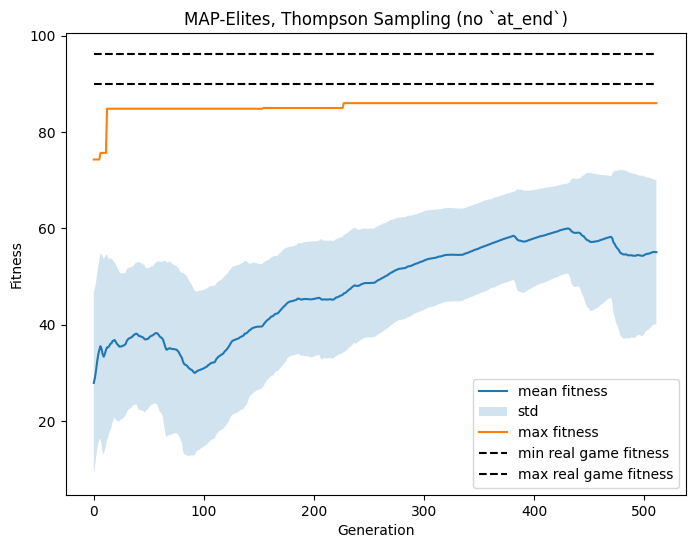

In [18]:
evo_sampler_map_elites_thompson_no_at_end = typing.cast(MAPElitesSampler, utils.load_data('2023_05_05', 'samples', 'evo_sampler_map_elites_thompson_final'))
plot_sampler_fitness_trajectory(evo_sampler_map_elites_thompson_no_at_end, 'MAP-Elites, Thompson Sampling (no `at_end`)')

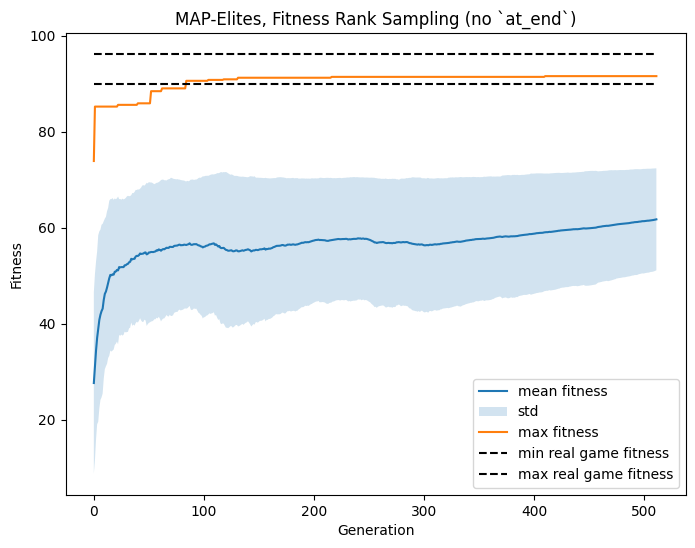

In [19]:
evo_sampler_map_elites_fitness_rank_no_at_end = typing.cast(MAPElitesSampler, utils.load_data('2023_05_05', 'samples', 'evo_sampler_map_elites_fitness_rank_final'))
plot_sampler_fitness_trajectory(evo_sampler_map_elites_fitness_rank_no_at_end, 'MAP-Elites, Fitness Rank Sampling (no `at_end`)')

In [16]:
key = evo_sampler_map_elites_fitness_rank_no_at_end.visualize_top_sample(5)
# TODO: wtf happens with index 3
print_nearest_real_games(evo_sampler_map_elites_fitness_rank_no_at_end.population[key], 3)

Sample features:
num_preferences_defined_1: 1
num_preferences_defined_2: 0
num_preferences_defined_3: 0
compositionality_structure_0: 0
compositionality_structure_1: 0
compositionality_structure_2: 1
compositionality_structure_3: 0
compositionality_structure_4: 0
compositionality_structure_5: 0
compositionality_structure_6: 0
compositionality_structure_7: 0
compositionality_structure_8: 0
compositionality_structure_9: 0
section_doesnt_exist_setup: 1
section_doesnt_exist_terminal: 1


### Energy of visualized game: -89.128

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                              |
|----------------------------------------------------------------------------|-----------------------------------------------------------------------|
| agent_holds_arg_types_balls_constraints: **1.218** = (1.000) * 1.218       | ast_ngram_full_n_7_score: **-30.569** = (0.860) * -35.542             |
| max_depth_scoring_1: **1.127** = (1.000) * 1.127                           | ast_ngram_constraints_n_7_score: **-23.312** = (0.922) * -25.280      |
| max_number_variables_types_quantified_types_1: **0.628** = (1.000) * 0.628 | all_variables_used: **-5.493** = (1.000) * -5.493                     |
| node_count_scoring_0: **0.462** = (1.000) * 0.462                          | all_preferences_used: **-5.038** = (1.000) * -5.038                   |
| compositionality_structure_2: **0.237** = (1.000) * 0.237                  | ast_ngram_scoring_n_5_score: **-4.912** = (0.987) * -4.976            |
| no_adjacent_same_modal: **0.106** = (1.000) * 0.106                        | mean_depth_setup_0: **-2.534** = (1.000) * -2.534                     |
|                                                                            | node_count_setup_0: **-2.375** = (1.000) * -2.375                     |
|                                                                            | max_depth_setup_0: **-2.316** = (1.000) * -2.316                      |
|                                                                            | section_doesnt_exist_setup: **-2.291** = (1.000) * -2.291             |
|                                                                            | all_variables_defined: **-2.285** = (1.000) * -2.285                  |
|                                                                            | num_preferences_defined_1: **-1.546** = (1.000) * -1.546              |
|                                                                            | length_of_then_modals_2: **-1.380** = (1.000) * -1.380                |
|                                                                            | max_quantification_count_setup_0: **-1.127** = (1.000) * -1.127       |
|                                                                            | section_doesnt_exist_terminal: **-1.101** = (1.000) * -1.101          |
|                                                                            | mean_depth_scoring_1: **-1.080** = (1.000) * -1.080                   |
|                                                                            | predicate_under_modal_once_agent_holds: **-0.955** = (1.000) * -0.955 |
|                                                                            | max_depth_terminal_0: **-0.945** = (1.000) * -0.945                   |
|                                                                            | node_count_terminal_0: **-0.934** = (1.000) * -0.934                  |
|                                                                            | mean_depth_terminal_0: **-0.899** = (1.000) * -0.899                  |
|                                                                            | max_depth_constraints_1: **-0.676** = (1.000) * -0.676                |

### Game:

```pddl
(define (game evo-135-56-0) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - ball)
        (then
          (once (agent_holds ?v0) )
          (hold (and (not (agent_holds ?v0) ) ) )
        )
      )
    )
  )
)
(:scoring
  (count preference0)
)
)
```

Nearest real game #1 (edit distance 82, real game nearest neighbor distances [149, 149, 203]):

(define (game 56cf6e8d31a5bc0006e1cdf5-65) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference ballOnBedAtEnd
      (exists (?b - ball)
        (at-end
          (on bed ?b)
        )
      )
    )
  )
)
(:scoring
  (count-once-per-objects ballOnBedAtEnd)
)
)

Nearest real game #2 (edit distance 90, real game nearest neighbor distances [144, 146, 149]):

(define (game 5bb511c6689fc5000149c703-29) (:domain few-objects-room-v1)
(:constraints
  (and
    (preference objectOnBed
      (exists (?g - game_object)
        (at-end
          (and
            (not
              (same_type ?g pillow)
            )
            (on bed ?g)
          )
        )
      )
    )
  )
)
(:scoring
  (count objectOnBed)
)
)

Nearest real game #3 (edit distance 101, real game nearest neighbor distances [28, 28, 61]):

(define (game 5ba855d47c0ebe0001272f70-79) (:domain many-objects-room-v1)
(:const

In [9]:
for k, g in evo_sampler_map_elites_fitness_rank_no_at_end.population.items():
    f = evo_sampler_map_elites_fitness_rank_no_at_end._score_proposal(g)
    if not np.isclose(f, evo_sampler_map_elites_fitness_rank_no_at_end.fitness_values[k]):
        print(k, f, evo_sampler_map_elites_fitness_rank_no_at_end.fitness_values[k])

16609 47.73816680908203 60.02877426147461
8372 56.35838317871094 63.53390121459961
17024 60.130897521972656 58.510982513427734
24780 68.39381408691406 70.07616424560547
24652 63.1774787902832 64.85983276367188
9440 47.037899017333984 52.40708541870117
9364 52.647125244140625 59.8226432800293
25728 71.8910903930664 73.57343292236328
24729 54.062782287597656 63.722782135009766
9892 57.120323181152344 63.79457092285156
9360 51.82366180419922 52.3249397277832
25225 61.83921432495117 67.20840454101562
24761 68.35872650146484 69.7869644165039
24745 66.62194061279297 68.05017852783203
1592 31.14585304260254 38.92424011230469
716 38.000221252441406 45.77860641479492
8897 58.535736083984375 60.488365173339844
156 56.0591926574707 57.4874382019043
16522 57.06959915161133 58.68951416015625
8940 48.42879104614258 50.111148834228516
16594 51.93830871582031 53.5582275390625
8908 55.07896423339844 56.260047912597656
9452 42.95001983642578 46.458709716796875
1696 30.519113540649414 35.46938705444336
2

In [ ]:
def real_games_to_keys(map_elites_sampler: MAPElitesSampler, real_asts: typing.List[tatsu.ast.AST]) -> typing.List[str]:
    return set([map_elites_sampler._features_to_key(map_elites_sampler._proposal_to_features(ast)) for ast in real_asts])
    

real_game_keys = real_games_to_keys(evo_sampler_map_elites_no_at_end, game_asts)
high_quality_sample_keys = set([k for k, v in evo_sampler_map_elites_no_at_end.fitness_values.items() if v > 75])
high_quality_no_real_game_keys = high_quality_sample_keys - real_game_keys
print(len(real_game_keys), len(high_quality_sample_keys), len(real_game_keys.intersection(high_quality_sample_keys)), len(high_quality_no_real_game_keys))


In [ ]:
i = 9
high_quality_no_real_game_keys_list = list(high_quality_no_real_game_keys)
key = high_quality_no_real_game_keys_list[i]

evo_sampler_map_elites_no_at_end._visualize_sample_by_key(key)
print_nearest_real_games(evo_sampler_map_elites_no_at_end.population[key], 3)